In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)

from keras import models
from keras import optimizers
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GlobalAveragePooling1D

from attention.layers import AttentionLayer

Using TensorFlow backend.


# Generating the dataset

This taks is a bit more challenging than the copy task on `example.ipynb`. In this case we want to sum
both numbers marked with $1$ in the second line of the tape.


Each sample is a "tape" formed by two rows: the top row $y[0]$ contains random numbers sampled from the interval $[0, 1)$, while the second, $y[1]$, is formed by a string of zeros, except for two positions, which have a one. The model is trained as a regressor to produce on the output the sum of the marked values from the first row. For example, given:

$$ X = 
\begin{bmatrix}
    0.13 & 0.01 & 0.11 & 0.32 & 0.24 & 0.01 \\
    0    & 1    & 0    & 0    &   1  & 0    \\
\end{bmatrix},
$$

the model output should be $\mathcal{M}_\theta(X) = 0.25$. We train two models, one using the attention mechanism and another using an average pooling. This models should be a bit more powerful than the one seen in `example.ipynb`.

In [2]:
N_SAMPLES = 1000
N_TIMESTEPS = 32

# X = (b, t, d)
X = np.random.rand(N_SAMPLES, N_TIMESTEPS, 1)
F = np.zeros_like(X)

# X[b, t, 0] = number
# X[b, t, 1] = flag
X = np.concatenate([X, F], axis=2)

Y = list()
sampling_range = list(range(N_TIMESTEPS))
for sample in range(N_SAMPLES):
    a, b = np.random.choice(sampling_range, size=2, replace=False)
    
    X[sample][a][1] = 1
    X[sample][b][1] = 1
    
    Y.append(X[sample][a][0] + X[sample][b][0])

# Y = (b, sum, 1)
Y = np.asarray(Y).reshape(-1, 1)

for sample in range(3):
    print(f'{X[sample]}\nsum = {Y[sample][0]}\n')

[[0.26202468 1.        ]
 [0.15868397 0.        ]
 [0.27812652 0.        ]
 [0.45931689 0.        ]
 [0.32100054 0.        ]
 [0.51839282 0.        ]
 [0.26194293 0.        ]
 [0.97608528 0.        ]
 [0.73281455 0.        ]
 [0.11527423 0.        ]
 [0.38627507 0.        ]
 [0.62850118 1.        ]
 [0.12505793 0.        ]
 [0.98354861 0.        ]
 [0.44322487 0.        ]
 [0.78955834 0.        ]
 [0.79411858 0.        ]
 [0.36126157 0.        ]
 [0.41610394 0.        ]
 [0.58425813 0.        ]
 [0.76017177 0.        ]
 [0.18780841 0.        ]
 [0.28816715 0.        ]
 [0.67021886 0.        ]
 [0.49964826 0.        ]
 [0.17856868 0.        ]
 [0.4131413  0.        ]
 [0.19919524 0.        ]
 [0.5316994  0.        ]
 [0.8323707  0.        ]
 [0.18525095 0.        ]
 [0.95735922 0.        ]]
sum = 0.8905258545552933

[[0.42541467 0.        ]
 [0.50400704 0.        ]
 [0.51047095 0.        ]
 [0.01579145 0.        ]
 [0.73169007 0.        ]
 [0.99330504 1.        ]
 [0.16287753 0.        

# Training both models

In [3]:
def build_average_model():
    model_in = Input((N_TIMESTEPS, 2), name='tape-in')
    vectors  = LSTM(units=4, return_sequences=True, name='lstm')(model_in)
    avg_pool = GlobalAveragePooling1D(name='eita_james')(vectors)
    output   = Dense(1, activation='linear', name='linear')(avg_pool)

    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()

    # 0.05, 0.1
    model.compile(optimizers.Adam(lr=1e-1), 'mse')
    return model

avg_model = build_average_model()
avg_model.fit(X, Y, batch_size=32, epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tape-in (InputLayer)         (None, 32, 2)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32, 4)             112       
_________________________________________________________________
eita_james (GlobalAveragePoo (None, 4)                 0         
_________________________________________________________________
linear (Dense)               (None, 1)                 5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2385
Epoch 2/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1657
Epoch 3/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1626
Epoch 4/20
1000/1000 [=====

In [4]:
def build_attention_model():
    model_in = Input((N_TIMESTEPS, 2), name='tape-in')
    vectors  = LSTM(units=4, return_sequences=True, name='lstm')(model_in)
    attended = AttentionLayer(name='attention')(vectors)
    output   = Dense(1, activation='linear')(attended)

    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()

    model.compile(optimizers.Adam(lr=5e-2), 'mse')
    return model

att_model = build_attention_model()
att_model.fit(X, Y, batch_size=32, epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tape-in (InputLayer)         (None, 32, 2)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32, 4)             112       
_________________________________________________________________
attention (AttentionLayer)   (None, 4)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1960
Epoch 2/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1651
Epoch 3/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1626
Epoch 4/20
1000/1000 [=====

# Comparing the losses

Interestingly on this particular case, the average model is almost as competitive as the attention model. Still, it's worhtwhile mentioning that the goal of these toy tasks are:

1. To ensure that the attention layer works properly
2. Visualize how it affects the model and how its weights are distributed across the timesteps
3. The average pooling can be seen as a special case of the attention model is $\alpha_i = \alpha_j \;\; \forall i, j$

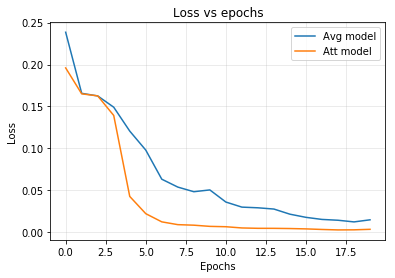

In [5]:
plt.plot(avg_model.history.history['loss'], label='Avg model')
plt.plot(att_model.history.history['loss'], label='Att model')
plt.legend()
plt.grid(alpha=0.3)
plt.title('Loss vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss');

In [6]:
def build_visualization_model(model):
    model_in = Input((N_TIMESTEPS, 2), name='tape-in')
    vectors  = LSTM(units=4, return_sequences=True, name='lstm',
                    weights=model.layers[1].get_weights())(model_in)

    weights = AttentionLayer(name='attention', return_attention=True,
                             weights=model.layers[2].get_weights())(vectors)

    model = models.Model(inputs=[model_in], outputs=[weights])
    model.summary()

    return model

viz_model = build_visualization_model(att_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tape-in (InputLayer)         (None, 32, 2)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32, 4)             112       
_________________________________________________________________
attention (AttentionLayer)   (None, 32)                24        
Total params: 136
Trainable params: 136
Non-trainable params: 0
_________________________________________________________________


# Visualizing the attention weights

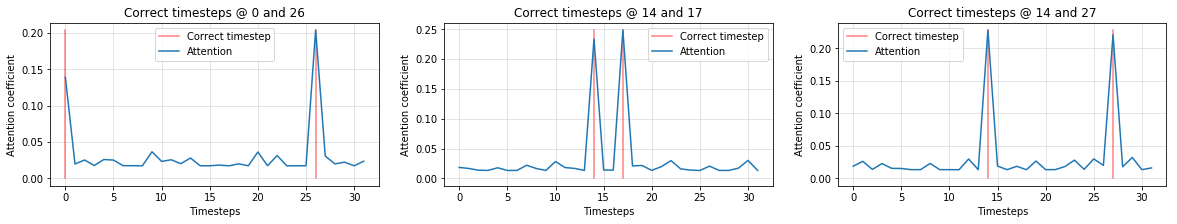

In [13]:
def plot_attention(viz_model, sample):
    # finding timesteps to be summed
    sum_coordinates = np.where(sample[:, 1] > 0.90)[0]

    # computing the attention coefficients and their maxima
    alphas = viz_model.predict(sample[None, :])[0]
    max_alpha = np.max(alphas)

    # utilities to plot the correct timesteps in the plot
    ys = np.linspace(0, max_alpha)
    attention1 = np.ones_like(ys) * sum_coordinates[0]
    attention2 = np.ones_like(ys) * sum_coordinates[1]

    plt.plot(attention1, ys, 'r', alpha=0.5, label='Correct timestep')
    plt.plot(attention2, ys, 'r', alpha=0.5)
    plt.plot(alphas, label='Attention')

    # making it pretty
    plt.xlabel('Timesteps')
    plt.ylabel('Attention coefficient')
    plt.grid(alpha=0.4)
    plt.legend()
    plt.title(f'Correct timesteps @ {sum_coordinates[0]} and {sum_coordinates[1]}')


picks = np.random.randint(0, N_SAMPLES, 3)
    
plt.figure(figsize=(20, 3))
plt.subplot(131)
plot_attention(viz_model, X[picks[0]])
plt.subplot(132)
plot_attention(viz_model, X[picks[1]])
plt.subplot(133)
plot_attention(viz_model, X[picks[2]])

plt.show()